In [0]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import sklearn.model_selection as model_selection
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import SGD
from numpy import newaxis
import keras
import keras_metrics
from keras import backend as K
from sklearn.metrics import classification_report
import tensorflow as tf

In [100]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
from google.colab import files
uploaded = files.upload()

Saving Earthquake_TREC_2018_test.csv to Earthquake_TREC_2018_test.csv
Saving Floods_TREC_2018_test.csv to Floods_TREC_2018_test.csv


In [0]:
df3 = pd.read_csv(io.BytesIO(uploaded['Earthquake_TREC_2018_test.csv']))
df4 = pd.read_csv(io.BytesIO(uploaded['Floods_TREC_2018_test.csv']))

In [8]:
from google.colab import files
uploaded = files.upload()

Saving Earthquake_TREC_2018_train.csv to Earthquake_TREC_2018_train.csv
Saving flood_TREC_2018_train.csv to flood_TREC_2018_train.csv


In [0]:
import io
df1 = pd.read_csv(io.BytesIO(uploaded['flood_TREC_2018_train.csv']))
df2 = pd.read_csv(io.BytesIO(uploaded['Earthquake_TREC_2018_train.csv']))

In [0]:
'''
    Combining all into one big data frame
'''
df_c = pd.DataFrame()
df_c['Tweet'] = pd.concat([df1['Tweet'] , df2['Tweet'], df3['Tweet'], df4['Tweet'] ])
df_c['Priority'] = pd.concat([df1['Priority'] , df2['Priority'], df3['Priority'], df4['Priority']])


In [0]:
'''
Creating a categorical variable to keep label critical tweets as 1 and 0 otherwise
'''
def to_categorical(df_c):
    t = []
    for element in df_c['Priority']:
        if element =='Critical':
            t.append(1)
        else:
            t.append(0)
        
    t = np.array(t)
    df_c['Target'] = t

    df_c['Target'] = df_c['Target'].astype('category')
    t = df_c['Target']
    del df_c['Target']
    return (t)

t = to_categorical(df_c)

In [0]:
'''
    Creating a function to input lemmatized text to possibly another function that outputs the tfidf in a csv format.
    We could also simply use the output from this funtion in an tfidf format (no csv) and train a model.
'''
def preProcess(df):
    df['Tweet'] = df['Tweet'].astype('str')
    
    token_array = []
    for tweet in df['Tweet']:
        token_tweet = word_tokenize(tweet)
        token_array.append(token_tweet)
        
    stop_words=set(stopwords.words("english"))
    filtered_token_array=[]
    for tweet in token_array:
        filtered_tweet = []
        for word in tweet:
                if word not in stop_words:
                    filtered_tweet.append(word)
        filtered_token_array.append(filtered_tweet)
        
    lem = WordNetLemmatizer()
    stem = PorterStemmer()

    lemmatized_array=[]
    for tweet in filtered_token_array:
        lemmatized_tweet = []
        for word in tweet:
            lemmatized_tweet.append(lem.lemmatize(word,'v'))
        lemmatized_array.append(lemmatized_tweet)
    
    lemmatized_array_join = []
    for element in lemmatized_array:
        lemmatized_array_join.append(''.join(element))
        
    return (lemmatized_array_join)


In [0]:
'''
    Plot no skill and ROC curve
'''
def plot_roc_curve(test_y, naive_probs, model_probs):
	# plot naive skill roc curve
	fpr, tpr, _ = roc_curve(test_y, naive_probs)
	plt.plot(fpr, tpr, linestyle='--', label='No Skill')
	# plot model roc curve
	fpr, tpr, _ = roc_curve(test_y, model_probs)
	plt.plot(fpr, tpr, marker='.', label='SVM SGD')
	# axis labels
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	# show the legend
	plt.legend()
	# show the plot
	plt.show()

In [0]:
'''
    Plot no skill model and PR curve
'''
def plot_pr_curve(test_y, model_probs):
	# calculate the no skill line as the proportion of the positive class
	no_skill = len(test_y[test_y==1]) / len(test_y)
	# plot the no skill precision-recall curve
	plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
	# plot model precision-recall curve
	precision, recall, _ = precision_recall_curve(test_y, model_probs)
	plt.plot(recall, precision, marker='.', label='SVM SGD')
	# axis labels
	plt.xlabel('Recall')
	plt.ylabel('Precision')
	# show the legend
	plt.legend()
	# show the plot
	plt.show()

In [0]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [185]:
'''
    DTM to get TF-IDF features
'''
tf=TfidfVectorizer()
lemmatized_array_join = preProcess(df_c)
text_tf= tf.fit_transform(lemmatized_array_join).toarray()

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [0]:
'''
    Let us now balance the dataset and see what happens. We have 52 critical tweets so lets balance that with
    200 low priority tweets.
'''
df_low = df_c[df_c['Priority'] == 'Low'].sample(500)
df_crit = df_c[df_c['Priority'] == 'Critical']
df_lc = pd.concat([df_low, df_crit])
df_lc = shuffle(df_lc)

In [239]:
'''
    Convert to categorical
'''
t_lc = to_categorical(df_lc)
'''
    Getting a DTM of tf-idf features
'''
tf=TfidfVectorizer()
lemmatized_array_join = preProcess(df_lc)
text_lc= tf.fit_transform(lemmatized_array_join)
'''
    Converting DTM to array. REQUIRED TO DIRECTLY TRAIN SVM
'''
text_lc= tf.fit_transform(lemmatized_array_join).toarray()

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [0]:
'''
  Keras expects a 3D input layer. So we will reshape our x and y s
'''
text_lc = text_lc[:,:,newaxis]
t_lc = t_lc[:, newaxis]

In [241]:
'''
    A simple RNN using embedding layer and a SimpleRNN layer. 32 is the number of dimensions we wish to 
    embed into. Like 8 in the previous example we did for word embeddings.
'''
model_lc = Sequential()
model_lc.add(LSTM(units=32, input_shape = (text_lc.shape[1], 1), dropout=0.2, return_sequences=False))
#model_lc.add(Dense(8, activation = 'relu', input_shape = (text_tf.shape[1],)))
model_lc.add(Dense(units=1, activation='softmax'))
model_lc.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[keras.metrics.FalseNegatives(), keras.metrics.FalsePositives()])
history_lc = model_lc.fit(text_lc, t_lc, epochs=5, batch_size=256, validation_split=0.3, shuffle = True )

Train on 388 samples, validate on 167 samples
Epoch 1/5
388/388 [==============================] - 7s 17ms/step - loss: 13.7525 - false_negatives_2: 0.0000e+00 - false_positives_2: 348.0000 - val_loss: 13.8795 - val_false_negatives_2: 0.0000e+00 - val_false_positives_2: 152.0000
Epoch 2/5
388/388 [==============================] - 6s 16ms/step - loss: 13.7525 - false_negatives_2: 0.0000e+00 - false_positives_2: 348.0000 - val_loss: 13.8795 - val_false_negatives_2: 0.0000e+00 - val_false_positives_2: 152.0000
Epoch 3/5
388/388 [==============================] - 6s 16ms/step - loss: 13.7525 - false_negatives_2: 0.0000e+00 - false_positives_2: 348.0000 - val_loss: 13.8795 - val_false_negatives_2: 0.0000e+00 - val_false_positives_2: 152.0000
Epoch 4/5
388/388 [==============================] - 6s 16ms/step - loss: 13.7525 - false_negatives_2: 0.0000e+00 - false_positives_2: 348.0000 - val_loss: 13.8795 - val_false_negatives_2: 0.0000e+00 - val_false_positives_2: 152.0000
Epoch 5/5
388/388 

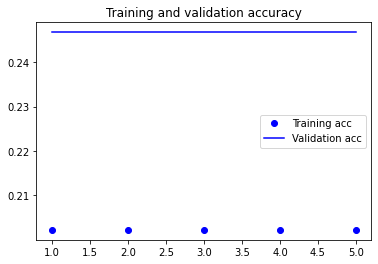

In [213]:
'''
    Plotting accuracy VS epoch for training and validations
'''
acc = history_lc.history['accuracy']
val_acc = history_lc.history['val_accuracy']
loss = history_lc.history['loss']
val_loss = history_lc.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

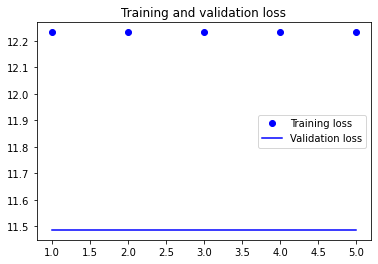

In [242]:

'''
    Plotting loss VS epoch for training and validations
'''
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()